Q-Learning derived from: https://www.kaggle.com/phunghieu/connectx-with-q-learning

In [6]:
from google.colab import files
files.upload() #upload kaggle.json
 
!pip install pip --upgrade
!pip install notebook --upgrade 
!pip install -q kaggle

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 1.5MB 5.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 9.5 MB 5.5 MB/s 
  Attempting uninstall: notebook
    Found existing installation: notebook 5.3.1
    Uninstalling notebook-5.3.1:
      Successfully uninstalled notebook-5.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook~=5.3.0; python_version >= "3.0", but you have notebook 6.1.5 which is incompatible.


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user joehoho — sort-by dateRun
!pip install 'kaggle-environments>=0.1.6'

!ls

kaggle.json
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: — user joehoho — sort-by dateRun
     |████████████████████████████████| 106 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 2.6 MB/s 
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.1 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
kaggle.json  sample_data


In [8]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from random import choice
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make
from kaggle_environments import agent as utils

#ignore load football failed, common issue

Loading environment football failed: No module named 'gfootball'


In [9]:
def encode_line(a,b,c,d) :
    return int(a + b*1e2 + c*1e4 + d*1e6)

def create_lines_by_index():
    lines_by_index = {}
    for i in range(42):
        lines_by_index[i] = []
    for r in range(6):
        for c in range(7):
            for direction in [ (0, 1), (1,1), (1,0), (1,-1) ]:
                dx,dy = direction
                for start in [-3, -2, -1, 0]:
                    line = []
                    for l in range(4):
                        _r = r + (start+l) * dy
                        _c = c + (start+l) * dx
                        if _r > -1 and _r < 6 and _c > -1 and _c < 7:
                            line.append( _r * 7 + _c)
                    if len(line) == 4:
                        encoded_line = encode_line(*sorted(line))
                        for idx in line:
                            if not encoded_line in lines_by_index[idx]:
                                lines_by_index[idx].append(encoded_line)                      
    return lines_by_index

def create_count_by_line(lines_by_index):
    lines = sorted({x for v in lines_by_index.values() for x in v})
    return dict(zip(lines , [0] * len(lines)))
    
def  update_count_by_line(count_by_lines, lines_by_index, idx, color):
    for encoded_line in lines_by_index[idx] :
        if encoded_line in count_by_lines :
            if color * count_by_lines[encoded_line] >= 0 : 
                count_by_lines[encoded_line] = count_by_lines[encoded_line] + color
            else :
                count_by_lines.pop(encoded_line, None)
    return count_by_lines

def compute_count_by_line(count_by_lines, lines_by_index, board):
    for idx in reversed(range(42)):
        if board[idx] != 0 :
            count_by_lines = update_count_by_line(count_by_lines, lines_by_index, idx, 1 if  board[idx] == 1 else -1)
    return count_by_lines

def lookahead(board, lines_by_index, count_by_lines, search_max, depth, side, moves) :
    if depth == 0:
        return moves, get_heuristic_score(count_by_lines)
    color = 1 if search_max else -1
    best_score, best_moves = -1e16 if search_max else 1e16, []
    for r,c in get_valid_moves(board):
        new_board, new_moves = make_move(board, moves, color, r, c)
        new_count_by_lines = update_count_by_line(count_by_lines.copy(), lines_by_index, r*7 + c, color)
        if get_winner(new_count_by_lines) == color:
            score = (1e8-len(new_moves)) * color 
        else :
            new_moves, score = lookahead(new_board, lines_by_index, new_count_by_lines, 
                not search_max, depth-1, side, new_moves)
        if  (search_max and  score > best_score) or  (not search_max and score < best_score):
            best_score, best_moves  = score, new_moves
    #print("LEVEL = " + str(depth) + " return " + str(best_moves) + " with score " + str(best_score))
    return best_moves, best_score         

def lookahead_agent(obs, config, depth=3):
    depth = estimate_depth(obs.board, depth)
    if sum(x != 0 for x in obs.board) < 2:
        return 3
    lines_by_index = create_lines_by_index()
    count_by_line = create_count_by_line(lines_by_index)
    count_by_line = compute_count_by_line(count_by_line, lines_by_index, obs.board)    
    moves, score  = lookahead(obs.board.copy(), lines_by_index, count_by_line, 
        True if obs.mark == 1 else False, depth , 1 if obs.mark == 1 else -1, [])       
    return moves[0]

def estimate_depth(board, default_depth):
    depth = default_depth
    move_cnt = sum(x != 0 for x in board)
    if move_cnt > 25:
        depth = depth +  int((move_cnt-25) / 5)
    open_row_cnt = len(get_valid_moves(board))
    depth = depth + (7 - open_row_cnt)
    depth = min(42 - move_cnt, depth)
    return depth

def get_heuristic_score(count_by_lines) :
    scores = { -3 : -50, -2 : -10, -1 : -1, 0: 0, 1 : 1, 2 : 10, 3 : 50  }
    return sum( scores[x] for x in count_by_lines.values())

def get_winner(count_by_lines):
    return 1 if count_by_lines and max(count_by_lines.values()) == 4 else -1 if count_by_lines and min(count_by_lines.values()) == -4 else 0
    
def get_free_row(board, col):
    for row in reversed(range(6)) :
        if  board[row*7 + col] == 0:
            return row
    return -1

def get_valid_moves(board):
    return [ (get_free_row(board, col), col) for col in range(7) if get_free_row(board, col) != -1 ]
    
def make_move(board, moves, color, r, c):
    new_moves = moves.copy()
    new_moves.append(c)
    new_board = board.copy()
    new_board[r*7+c] = color
    return new_board, new_moves

def agent_depth1(obs, config):
    return lookahead_agent(obs, config, 1)

def agent_depth3(obs, config):
    return lookahead_agent(obs, config, 3)

def agent_depth5(obs, config):
    return lookahead_agent(obs, config, 5)

def agent_depth6(obs, config):
    return lookahead_agent(obs, config, 6)

In [10]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob
        
        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)

    def run(self, agents):
        return self.env.run(agents)



class QTable:
    def __init__(self, action_space):
        self.table = dict()
        self.action_space = action_space
        
    def add_item(self, state_key):
        self.table[state_key] = list(np.zeros(self.action_space.n))
        
    def __call__(self, state):
        board = state['board'][:] # Get a copy
        board.append(state.mark)
        state_key = np.array(board).astype(str)
        state_key = hex(int(''.join(state_key), 3))[2:]
        if state_key not in self.table.keys():
            self.add_item(state_key)
        
        return self.table[state_key]

In [11]:
env = ConnectX()

alpha = .1
gamma = 0.6
epsilon = 0.9
min_epsilon = 0.1

episodes = 40000

alpha_decay_step = 1000
alpha_decay_rate = 0.9
epsilon_decay_rate = 0.999925

In [12]:
q_table = QTable(env.action_space)

all_epochs = []
all_total_rewards = []
all_avg_rewards = [] # Last 100 steps
all_qtable_rows = []
all_epsilons = []

In [ ]:
for i in tqdm(range(episodes)):
    state = env.reset()

    epsilon = max(min_epsilon, epsilon * epsilon_decay_rate)
    epochs, total_rewards = 0, 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = choice([c for c in range(env.action_space.n) if state['board'][c] == 0])
        else:
            row = q_table(state)[:]
            selected_items = []
            for j in range(env.action_space.n):
                if state['board'][j] == 0:
                    selected_items.append(row[j])
                else:
                    selected_items.append(-1e7)
            action = int(np.argmax(selected_items))
        
        next_state, reward, done, info = env.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 5
        else:
            reward = -0.05 # Try to prevent the agent from taking a long move

        old_value = q_table(state)[action]
        next_max = np.max(q_table(next_state))
        
        # Update Q-value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table(state)[action] = new_value

        state = next_state
        epochs += 1
        total_rewards += reward


    all_epochs.append(epochs)
    all_total_rewards.append(total_rewards)
    avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
    all_avg_rewards.append(avg_rewards)
    all_qtable_rows.append(len(q_table.table))
    all_epsilons.append(epsilon)

    if (i+1) % alpha_decay_step == 0:
        alpha *= alpha_decay_rate



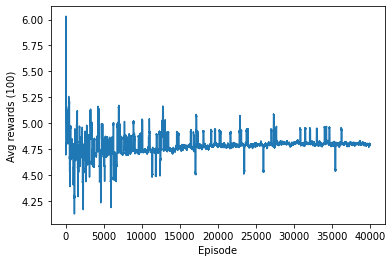

In [ ]:
len(q_table.table)

plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

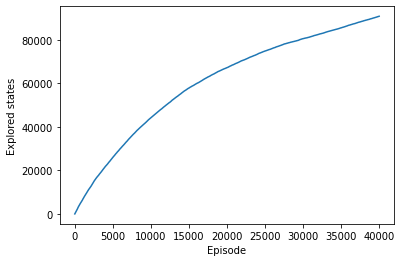

In [ ]:
plt.plot(all_qtable_rows)
plt.xlabel('Episode')
plt.ylabel('Explored states')
plt.show()

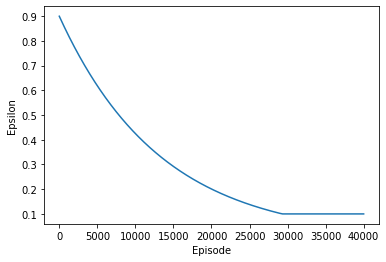

In [ ]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [ ]:
tmp_dict_q_table = q_table.table.copy()
dict_q_table = dict()

for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))

my_agent = '''def my_agent(observation, configuration):
    from random import choice

    q_table = ''' \
    + str(dict_q_table).replace(' ', '') \
    + '''

    board = observation.board[:]
    board.append(observation.mark)
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]

    if state_key not in q_table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    action = q_table[state_key]

    if observation.board[action] != 0:
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    return action
    ''' 

with open('submission.py', 'w') as f:
    f.write(my_agent)

Validate

In [13]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

Render tests won't run on larger trained sessions (disconnects from Colab)

In [ ]:
from submission import my_agent

# Run once to observe the procedure is implemented correctly
print("My agent vs Random")
env.run([my_agent, "random"])
env.render(mode="ipython")
env.reset()

print("My agent vs Negamax")
env.run([my_agent, "negamax"])
env.render(mode="ipython")
env.reset()

print("My agent vs Depth 5")
env.run([my_agent, agent_depth5])
env.render(mode="ipython")
env.reset()

print("Depth 5 vs Negamax")
env.run([agent_depth5, "negamax"])
env.render(mode="ipython")
env.reset()


My agent vs Random


In [ ]:
from submission import my_agent

# Run once to observe the procedure is implemented correctly


# Determine the winning percentages with
print("my agent vs random")
get_win_percentages(agent1=my_agent, agent2="random")

# Run once to observe the procedure is implemented correctly
#env.run([my_agent, "negamax"])
#env.render(mode="ipython")
#env.reset()
print("\ndepth 1 vs negamax")
get_win_percentages(agent1=agent_depth1, agent2="negamax")

print("\ndepth 3 vs negamax")
get_win_percentages(agent1=agent_depth3, agent2="negamax")
# Determine the winning percentages with
print("\ndepth 5 vs negamax")
get_win_percentages(agent1=agent_depth5, agent2="negamax")

print("\ndepth 3 vs depth 5")
get_win_percentages(agent1=agent_depth3, agent2=agent_depth5)

print("\nmy agent vs depth 1")
get_win_percentages(agent1=my_agent, agent2=agent_depth1)

my agent vs random
Agent 1 Win Percentage: 0.57
Agent 2 Win Percentage: 0.43
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0

depth 1 vs negamax
Agent 1 Win Percentage: 0.45
Agent 2 Win Percentage: 0.54
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0

depth 3 vs negamax
Agent 1 Win Percentage: 0.96
Agent 2 Win Percentage: 0.01
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0

depth 5 vs negamax
Agent 1 Win Percentage: 0.99
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0

depth 3 vs depth 5
Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0

my agent vs depth 1
Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [14]:
print("\ndepth 5 vs negamax")
get_win_percentages(agent1=agent_depth5, agent2="negamax")

print("\ndepth 6 vs negamax")
get_win_percentages(agent1=agent_depth6, agent2="negamax")

print("\ndepth 5 vs depth 6")
get_win_percentages(agent1=agent_depth5, agent2=agent_depth6)


depth 5 vs negamax
Agent 1 Win Percentage: 0.97
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0

depth 6 vs negamax
Agent 1 Win Percentage: 0.98
Agent 2 Win Percentage: 0.01
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0

depth 5 vs depth 6
Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [ ]:
from submission import my_agent

env = make("connectx", debug=True)
env.run([my_agent, my_agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

Success!


Render tests won't run on larger trained sessions (disconnects from Colab)

In [ ]:
from submission import my_agent
env.run([my_agent, my_agent])
env.render(mode="ipython")
env.reset()

In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission40k.py")

<function my_agent at 0x7fc506b499d8> written to submission40k.py


In [ ]:
from google.colab import files
files.download('submission40k.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>